## Notebook 2: Random Forest Model

Train a robust baseline model using the molecular fingerprints we generated. We will use a RandomForestClassifier from scikit-learn, which is powerful and has no complex dependencies.


### Setup

In [24]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import ast 

print("Libraries imported successfully.")

Libraries imported successfully.


### Load the Processed Data

In [25]:
try:
    df = pd.read_csv('../data/processed/dili_data_clean.csv')
    print("Processed data loaded successfully.")
    print(f"Shape of the dataset: {df.shape}")
except FileNotFoundError:
    print("Error: dili_data_clean.csv not found.")
    print("Please make sure the file from Notebook 1 is in the 'data/processed/' directory.")

Processed data loaded successfully.
Shape of the dataset: (910, 5)


### Prepare Data for Modeling

The fingerprints are currently stored as a string representation of a list. We need to convert this back into an actual list of numbers for the model.

In [26]:
# Drop rows with missing fingerprints
df.dropna(subset=['fingerprint'], inplace=True)

# Safely convert the string representation of the list back into a list of integers
df['fingerprint'] = df['fingerprint'].apply(ast.literal_eval)

# Separate features (X) and target (y)
X = np.array(df['fingerprint'].tolist())
y = df['dili_concern'].values

print(f"Features (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")

Features (X) shape: (907, 1024)
Target (y) shape: (907,)


### Define and Train the Model using Cross-Validation

We will use a **Stratified K-Fold Cross-Validation** strategy. This is a robust way to evaluate a model on a relatively small dataset. It ensures that each "fold" or split of the data has the same proportion of positive and negative samples as the whole dataset.

We will evaluate the model on two key metrics:
- **Accuracy:** The percentage of correct predictions.
- **ROC AUC:** A more nuanced metric for binary classifiers that measures the model's ability to distinguish between classes. An AUC of 0.5 is random guessing, and 1.0 is a perfect classifier.



In [27]:
# Initialize the RandomForest Classifier
# We use class_weight='balanced' to handle the class imbalance automatically
model = RandomForestClassifier(
    n_estimators=100,       
    class_weight='balanced',
    random_state=42
)

# Initialize the cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation for Accuracy
accuracy_scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')

# Perform cross-validation for ROC AUC
roc_auc_scores = cross_val_score(model, X, y, cv=cv, scoring='roc_auc')

print("Cross-validation finished.")

Cross-validation finished.


### Evaluate the Results

In [28]:
print("Baseline Model Performance (5-Fold Cross-Validation)")
print(f"Average Accuracy: {np.mean(accuracy_scores):.3f} (+/- {np.std(accuracy_scores):.3f})")
print(f"Average ROC AUC:  {np.mean(roc_auc_scores):.3f} (+/- {np.std(roc_auc_scores):.3f})")

Baseline Model Performance (5-Fold Cross-Validation)
Average Accuracy: 0.768 (+/- 0.017)
Average ROC AUC:  0.761 (+/- 0.036)


### Train a Final Model and Visualize Results

For practical use, we'll train one final model on the *entire* dataset. We can then use this model to make predictions. We'll also generate a confusion matrix to see what kind of errors our model is making.


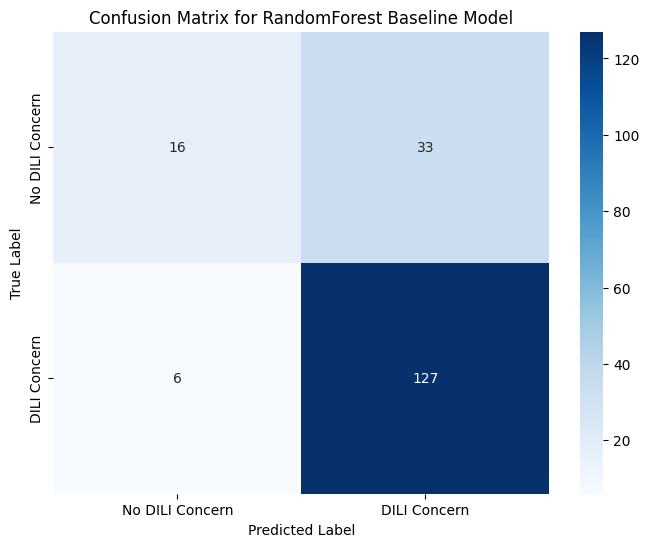

In [29]:
# Create a single train/test split to visualize the confusion matrix
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train the model on the training data
final_model = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42
)
final_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = final_model.predict(X_test)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No DILI Concern', 'DILI Concern'],
            yticklabels=['No DILI Concern', 'DILI Concern'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for RandomForest Baseline Model')
plt.show()